# INITIAL WHATEVER

In [1]:
import math
import numpy
import numpy.random
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import norm
from pt.plotter import *

set_default_plotter_options({
    'num_anomalies': [1, 2, 3, 4, 5],
    'transaction_events': [
        numpy.floor(10**x) for x in 
        [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5]
    ],
})

### Generate Data with Anomalies

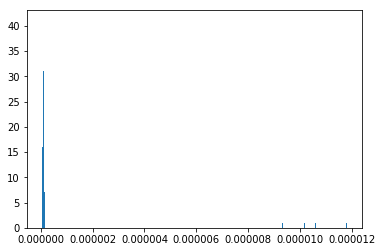

In [3]:
%matplotlib inline
rand = numpy.random.RandomState(seed=1234567)

def gen_data(events, *times):
    x = rand.normal(times[0], times[0]/5, events)
    
    d = 0
    for i in range(1, len(times)):
        t = times[i]
        num_anomalous_events = int(rand.normal(5, 1))
        for e in rand.normal(t, t/5, num_anomalous_events):
            x[d] = e
            d += 1

    rand.shuffle(x)
    return x

x = gen_data(100, 1e-7, 1e-5)
plot_data = matplotlib.pyplot.hist(x, 500)

Variables:
1. Number of points
2. Number of anomalies
3. Number of necessary starting data points
4. Frequency/Distribution of anomalies (e.g. what if a bunch happen close together vs far apart?)
5. Frequency/Distribution of data points in time

Experiment:
- Run algorithm on a set of data N times
- Measure the success of each run according to criteria below
- Aggregate that into a single number we can use to compare algorithms

Analysis Criteria:
- some sort of weighted sum of True Positive, False Positive, True Negative, and False Negative
- some sort of overhead calculation

Equipment Needed:
1. Function to generate data with anomalies in it that looks kind of realistic
    - Scrape durations from existing data
    - Add anomalies into it to form a composite data set
2. Function to calculate success criteria from a given run
3. Some algorithms

### Sanity Check

Check that method makes sense; for constant-size changes to the data over time, differences made when the baseline is smaller should show up more prominently than when the baseline is larger

In [ ]:
%matplotlib inline

p1 = numpy.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
p2 = numpy.array([1, 2, 4, 4, 5, 6, 7, 8, 9, 10])
p3 = numpy.array([1, 2, 3, 4, 5, 6, 8, 8, 9, 10])

matplotlib.pyplot.plot(numpy.cumsum(numpy.abs(numpy.diff(p2/p1))))
matplotlib.pyplot.plot(numpy.cumsum(numpy.abs(numpy.diff(p2)/numpy.diff(p1))))
#matplotlib.pyplot.plot(numpy.cumsum(numpy.abs(numpy.diff(p3/p1))))

## Come up with a way to calculate bin width and kernel width

63
63
7.937253933193772

1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
4
6
9


IQR delta 3.49875746223e-09
mean of deltas 9.29215313882e-09
median of deltas 7.69404377411e-09
sample std 2.69101820146e-08


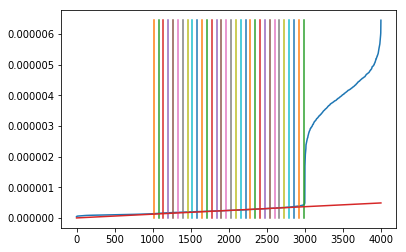

In [185]:
seed_points = 1000

seeds = numpy.array(
        list(gen_data(seed_points, 1e-7))
      + list(gen_data(seed_points, 2e-7))
      + list(gen_data(seed_points, 3e-7))
      + list(gen_data(seed_points, 4e-6)))

ls = len(seeds)

sorted_durations = sorted(seeds)
matplotlib.pyplot.plot(sorted_durations)

lsd = len(sorted_durations)
num_deltas = int(lsd ** 0.5)
points_per_bin = int(len(sorted_durations) / num_deltas)

print(num_deltas)
print(points_per_bin)
print(points_per_bin ** 0.5)

start = int(num_deltas / 4)
finish = int(3 * num_deltas / 4) + 1

mp = sorted_durations[-1]
last_marker = sorted_durations[int(start * lsd / num_deltas)]

deltas = []
for i in range(start+1, finish):
    x = int(lsd * i / num_deltas)
    d = sorted_durations[x]
    
    deltas.append(d - last_marker)
    last_marker = d
    
    matplotlib.pyplot.plot([x, x], [0, mp])
    
sorted_deltas = sorted(deltas)
print()
print("\n".join([str(int(round(x/sorted_deltas[0], 0))) for x in sorted_deltas]))
print()

midpoint = int(len(sorted_deltas) / 2)
if len(sorted_deltas) % 2 == 1:
    median_of_medians = sorted_deltas[midpoint]
else:
    median_of_medians = (sorted_deltas[midpoint - 1] + sorted_deltas[midpoint]) / 2

mean_of_medians = numpy.mean(sorted_deltas)
    
xdata = numpy.array(range(ls))
slope = median_of_medians / points_per_bin
intercept = sorted_durations[int(ls/2)] - slope * xdata[int(ls/2)]
ydata = slope * xdata + intercept
matplotlib.pyplot.plot(ydata)

p25 = sorted_durations[int(lsd * start / num_deltas)]
p75 = sorted_durations[int(lsd * (finish - 1) / num_deltas)]
IQR = (p75 - p25) / 1.349

print()
print("IQR delta", IQR / num_deltas)
print("mean of deltas", mean_of_medians)
print("median of deltas", median_of_medians)
print("sample std", numpy.std(sorted_durations) / num_deltas)


### Kernel Estimation Classes

In [214]:
class KernelEstimator(object):
    def __init__(self):
        self.histogram = {}
        self.tiles = {}
        self.kernels = {}
        
        self.overlaps = {}
        self.precisions = []
        
        self.base_precision = -1
        self.minimum_start = -1
        self.maximim_end = -1

        self.seed_mode = True
        self.seed_data = []
        self.seed_size = 0
        self.total_size = 0
        self.last_diff_total = 0
        
    def finish_seed_mode(self):
        self.seed_mode = False
        self._calculate_precision()

        self.seed_size = len(self.seed_data)
        #for duration in self.seed_data:
        #    self.add_data_point(duration, calc_diff=False)
            
    def plot_histogram(self):
        xdata = sorted([float(x) for x in self.histogram.keys()])
        ydata = [self.histogram['%5.3E' % x] for x in xdata]
        
        matplotlib.pyplot.xlim(min(xdata)/1.2, max(xdata)*1.05)
        matplotlib.pyplot.scatter(xdata, ydata)
        
    #############################################################
        
    def _gen_kernels(self, sizes):
        for size in sizes:
            n = self.kernel_width * size
            if n%2 == 0:
                n += 1
                
            self.kernels[size] = self._gen_kernel(n)
            self.kernels[size] /= sum(self.kernels[size])
            
    def _gen_kernel(self, size):
        return numpy.ones(size)
        
    def _align(self, value, precision):
        dividend = value // precision
        return dividend * precision
    
    def _lookup_precision(self, duration):
        last_node = len(self.precisions) - 1
        
        current_low = 0
        current_high = last_node
        
        while True:
            current_midpoint = (current_low + current_high) // 2
            node = self.precisions[current_midpoint]
            
            if (duration >= node[0]) and (duration < node[1]):
                return node[2:3]
            
            if duration < node[0]:
                if current_midpoint == 0:
                    return self.precisions[0][2:3]
                current_high = current_midpoint
                
            elif duration >= node[1]:
                if current_midpoint == last_node:
                    return self.precisions[last_node][2:3]
                current_low = current_midpoint

            else:
                raise Exception("What?")

    #############################################################

    # TODO: is there a way we can estimate the percentiles on-the-fly,
    #       without storing every seed data point?
    #       maybe https://en.wikipedia.org/wiki/Count%E2%80%93min_sketch ?
    def _calculate_precision(self):
        # TODO: this is bunk, as kernel_width should probably *SHRINK* with increasing number of points
        #
        # self.kernel_width = max(11, int(2 * points_per_bin ** 0.5))
        # if self.kernel_width % 2 == 0:
        #     self.kernel_width += 1
        
        self.kernel_width = 15
        
        sorted_durations = sorted(self.seed_data)
        lsd = len(sorted_durations)
        
        self.num_tiles = int(numpy.sqrt(lsd))
        tile = lsd / self.num_tiles
        points_per_bin = int(tile)
        last = sorted_durations[points_per_bin]
        
        tile_deltas = []
        tile_values = [last]
        for i in range(2, self.num_tiles - 1):
            d = sorted_durations[int(i * tile)]
            tile_deltas.append(d - last)
            tile_values.append(d)
            last = d

        sorted_deltas = sorted(tile_deltas)
        
        tile_delta_median = sorted_deltas[int(len(tile_deltas)/2)]
        # tile_delta_mean = numpy.mean(sorted_deltas)
        # tile_std = numpy.std(tile_values)
        # self.precision = ((tile_delta_median + tile_delta_mean) + tile_std / 10) / 3
        self.base_precision = tile_delta_median
        
        self._calculate_precision_regions(sorted_durations, deltas)
        self._calculate_overlap_regions(sorted_durations, deltas)
        # self._gen_kernels(kernel_sizes)
        
        print(tile_deltas)
        print()
        print(tile_values)
        print()
        print(kernel_sizes)
        
        # or should it be min(self.kernel) ?
        # self.min_delta = 1 / len(self.kernel)
        
    def _calculate_precision_regions(self, sorted_durations, deltas):
        hkw = self.kernel_width // 2
        
        current_precision = self.base_precision
        string_precision = '%5.3E' % current_precision
        current_ratio_to_previous = 1
        current_total_ratio = 1
        
        self.minimum_allowed = self.base_precision * hkw
        current_start = self.minimum_allowed
        minimum_end = 2 * current_start

        self.precisions = []
        precision_ratio = 1

        for i in range(2, self.num_tiles - 1):
            cp = deltas[i-2]
            if cp < self.base_precision:
                continue

            new_ratio = cp // current_precision
            
            # TODO: do we consider ratio < 0.5?
            if new_ratio < 2:
                continue
                
            new_precision = current_precision * new_ratio
            start_duration = sorted_durations[int(i * tile)]
            new_start = self._align(start_duration, new_precision)
            new_minimum = new_start - new_precision * hkw
            
            if new_minimum < minimum_end:
                continue
            
            self.histograms[current_precision] = {}
            self.precisions.append((
                current_start, new_start, 
                string_precision, current_precision,
                current_ratio, current_total_ratio))
            
            current_precision = new_precision
            string_precision = '%5.3E' % current_precision
            current_ratio_to_previous = new_ratio
            current_total_ratio *= new_ratio
            
            current_start = new_start
            minimum_end = new_start + new_precision * hkw

        new_start = current_precision * 1000 + minimum_end
        
        self.maximim_end = new_start
        self.histograms[current_precision] = {}
        self.precisions.append((
            current_start, new_start,
            string_precision, current_precision,
            current_ratio, current_total_ratio))

    def _calculate_overlap_regions(self):
        hkw = 1 + self.kernel_width // 2
        
        for i in range(1, len(self.precisions)):
            pp = self.precisions[i-1][3]
            psp = self.precisions[i-1][2]
            
            cp = self.precisions[i1][3]
            csp = self.precisions[i][2]
            
            ratio = self.precisions[i][4]
            midpoint_of_overlap = self.precisions[i][0]
            
            # first do the mapping from this tier to the lower tier
            for delta in range(-hkw, math.ceil(hkw / ratio)):
                point = midpoint_of_overlap + delta * cp
                index = '%5.3E' % point
                
                self.histogram[cp][index] = 0
                self.overlap.setdefault(index, {})
                self.overlap[index][cp] = []
                    
                    for i in range(ratio)
                ]
                
                for i in range(ratio):
                    inner = '%5.3E' % (point + pp * i)
                    
                    self.overlap[index][cp] = (csp, point, ratio)
                
            
    #############################################################
        
    # TODO: we can optimize this further by generating N sets of
    #       shifted kernels, each shifted by offset/N, and then just
    #       doing a lookup
    def _shift_kernel(self, size, offset):
        offset_fraction = offset / self.precision
        leftovers = 0
        shifted = []

        for slice in self.kernels[size]:
            shifted_part = offset_fraction * slice
            shifted.append(leftovers + offset_fraction * slice)
            leftovers = slice - shifted_part

        shifted.append(leftovers)
        return shifted

    def add_data_point(self, duration, calc_diff=True):
        if self.seed_mode:
            self.seed_data.append(duration)
            return

        self.total_size += 1
        
        # TODO store precision string
        string_precision, precision = self._lookup_precision(duration)
        histogram = self.histogram[string_precision]
        aligned_duration = self._align(duration, precision)
        offset = duration - aligned_duration
        shifted_kernel = self._shift_kernel(offset)
        
        hlsk = len(shifted_kernel) // 2
        krange = range(-1, lsk)
        indices = [
            '%5.3E' % (aligned_duration + (k - hlsk + 1) * precision)
            for k in krange
        ]
        
        old_vals = {}
        for k in krange:
            index = indices[k]
            histogram.setdefault(index, 0)
            
            if index in self.overlap:
                old_vals[index] = 0
                
                for other_string_precision, other_point, factor in self.overlap[index][string_precision]:
                    old_vals[index] += self.histogram[other_string_precision][other_point] / factor
                
            else:
                old_vals[index] = histogram[index]

        abs_diff_total = 0
        prev_ratio = 0.0
        scaling_factor = 1 # self.total_size / self.seed_size
        min_delta = self.min_delta

        for k in krange:
            if k == -1: continue

            kslice = shifted_kernel[k]
            index = indices[k]
            
            self.histogram.setdefault(index, 0)
            self.histogram[index] += scaling_factor * kslice

            if calc_diff:
                new_ratio = -1 + (self.histogram[index] + min_delta) / (old_vals[index] + min_delta)
                abs_diff_total += abs(new_ratio - prev_ratio)
                prev_ratio = new_ratio
                
        if not calc_diff:
            return
        
        self.last_diff_total = abs_diff_total
        return abs_diff_total > scaling_factor / 2

In [212]:
class GaussianKernelEstimator(KernelEstimator):
    def _gen_kernel(self, size):
        return norm.pdf(numpy.linspace(
                norm.ppf(0.01),
                norm.ppf(0.99),
                size))


### Quick Test for the Estimator

[6.23003924066532e-09, 3.6694862983234629e-09, 2.9919093575141894e-09, 2.4567212302909079e-09, 2.0647252236435589e-09, 1.7790807438787914e-09, 1.5745931437445271e-09, 1.4184220989997041e-09, 1.3512366790617006e-09, 1.1698852526648291e-09, 1.1423500650682739e-09, 9.6238371184281481e-10, 1.103442744387346e-09, 1.0077482039229212e-09, 8.8689036555796424e-10, 8.5314310206837377e-10, 8.038303498681803e-10, 8.3658577193564097e-10, 9.2976145543925511e-10, 7.9103480459094648e-10, 7.9512558746521123e-10, 6.9253035433252389e-10, 8.2537666628903011e-10, 8.033506937202449e-10, 7.6374394705239783e-10, 6.1646602645311027e-10, 6.8774435055638783e-10, 7.8748033343200491e-10, 7.1543883128103696e-10, 6.7870711165629163e-10, 7.2793217706660928e-10, 7.7180004521419951e-10, 7.87998932128656e-10, 7.8349196207886349e-10, 6.353815675841364e-10, 7.8948468724181304e-10, 7.0216535167438647e-10, 6.6491358857729608e-10, 7.2783631129080764e-10, 7.8827400034134915e-10, 7.8004419199793605e-10, 7.4047471969067991e-10,

ValueError: min() arg is an empty sequence

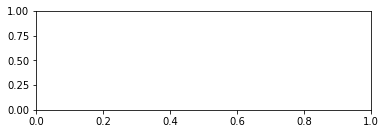

In [213]:
%matplotlib inline

seed_points = 10000
data_points = 10000
g = GaussianKernelEstimator()

seeds = numpy.array(
        list(gen_data(seed_points, 1e-7))
      + list(gen_data(seed_points, 1e-5)))

for duration in seeds:
    g.add_data_point(duration)

g.finish_seed_mode()

ax = matplotlib.pyplot.subplot(2, 1, 1)
# ax.set_xscale("log")
#g.plot_histogram()
#before_buckets = len(g.histogram.values())

"""
data = gen_data(data_points, 1e-7)
for duration in data:
    is_anomaly = g.add_data_point(duration)
    
    if is_anomaly:
        print(g.total_size, duration, g.last_diff_total, g.total_size / g.seed_size)

ax = matplotlib.pyplot.subplot(2, 1, 2)
"""
# ax.set_xscale("log")
g.plot_histogram()
print()
#print(before_buckets)
#print(len(g.histogram.values()))
print()
print(g.kernel_width)
print(g.precision)

In [210]:

g.add_data_point(8e-7)
print(g.last_diff_total)

TypeError: _shift_kernel() missing 1 required positional argument: 'offset'

3.1995976618201453e-07

In [58]:
(finish - 1 - start) * median_median

2.4033235855394082e-07

1.7730037991169301e-07